In [ ]:
pip install tensorflow numpy pandas matplotlib scikit-learn pillow

In [ ]:
# prepare_dataset.py
import os
import shutil
import random

def subsample_dataset(source_dir, target_dir, num_images_per_class=150):
    """
    Creates a new directory with a random subsample of images from each class.
    """
    # Create the target directory, erasing it if it already exists
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)

    print(f"Creating subsampled dataset at: {target_dir}")

    # Get the list of class directories (e.g., '0', '1', '2', ...)
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        source_class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path)

        # Get all image file names in the source class directory
        images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Ensure we don't try to sample more images than available
        num_to_sample = min(num_images_per_class, len(images))

        # Randomly select the images
        selected_images = random.sample(images, num_to_sample)

        # Copy selected images to the new directory
        for image_name in selected_images:
            shutil.copy(os.path.join(source_class_path, image_name), target_class_path)
        
        print(f"Class '{class_name}': Copied {len(selected_images)} images.")

    print("\nSubsampling complete!")

# --- CONFIGURATION ---
# IMPORTANT: Update these paths to match your system
SOURCE_DATASET_PATH = "ITS Dataset" 
TARGET_DATASET_PATH = "ITS_Subsampled"
# ---------------------

if __name__ == '__main__':
    subsample_dataset(SOURCE_DATASET_PATH, TARGET_DATASET_PATH)

IMPORT

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import random


CONFIGURATION

In [31]:
# --- CONFIGURATION ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 15 # For the initial warm-up training

# Paths to the new split dataset
BASE_DATA_PATH = "split_dataset"
TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'train')
VALIDATION_PATH = os.path.join(BASE_DATA_PATH, 'validation')
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test')

DATA PREPARTION AND AUGMENTATION


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Setting up data generators with standard rescaling for MobileNetV2...")

# The training generator uses standard rescaling and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # REVERTED: Back to simple rescaling
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# The validation generator ONLY rescales the images
validation_datagen = ImageDataGenerator(rescale=1./255) # REVERTED: Back to simple rescaling

# Create the generators from their respective directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"\nSuccessfully found {NUM_CLASSES} classes.")

Setting up data generators with standard rescaling for MobileNetV2...
Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.

Successfully found 58 classes.


BUILD THE MODEL

In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

print("\nBuilding the model using MobileNetV2...")

# Load the MobileNetV2 base model, pre-trained on ImageNet
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model for initial training
base_model.trainable = False

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Reverted to 128 units, suitable for MobileNetV2
x = Dropout(0.5)(x) 
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the safer initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()


Building the model using MobileNetV2...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 171,450 (669.73 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

INITIAL TRAINING OF THE MODEL

In [34]:
print("\nStarting initial warm-up training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    # class_weight=class_weights # Add this line
)

# Save the trained model
model.save("indian_traffic_sign_baseline.h5")
print("\nBaseline model saved as 'indian_traffic_sign_baseline.h5'")


Starting initial warm-up training...


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 115s 357ms/step - accuracy: 0.2378 - loss: 3.1636 - val_accuracy: 0.6288 - val_loss: 1.3408
Epoch 2/15
  1/304 ━━━━━━━━━━━━━━━━━━━━ 1:15 248ms/step - accuracy: 0.6875 - loss: 1.1526

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.6875 - loss: 1.1526 - val_accuracy: 0.6293 - val_loss: 1.3385
Epoch 3/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - accuracy: 0.5662 - loss: 1.4496 - val_accuracy: 0.6957 - val_loss: 1.0080
Epoch 4/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5938 - loss: 1.1523 - val_accuracy: 0.6933 - val_loss: 1.0059
Epoch 5/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 94s 310ms/step - accuracy: 0.6536 - loss: 1.1022 - val_accuracy: 0.7322 - val_loss: 0.8445
Epoch 6/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5625 - loss: 1.2365 - val_accuracy: 0.7293 - val_loss: 0.8423
Epoch 7/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 110s 361ms/step - accuracy: 0.6874 - loss: 0.9475 - val_accuracy: 0.7385 - val_loss: 0.7849
Epoch 8/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.6250 - loss: 0.9847 - val_accuracy: 0.7423 - val_loss: 0.7812
Epoch 9/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 112s 370ms/step - accuracy: 0.7264 - loss: 0.8406 - val_a


Baseline model saved as 'indian_traffic_sign_baseline.h5'


FINE TUNING THE MODEL

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n--- Starting Controlled Fine-Tuning ---")

# --- 1. Set up Cautious Unfreezing ---
base_model.trainable = True

# We will fine-tune from the last convolutional block onwards.
# For MobileNetV2, a good starting point is around layer 140.
fine_tune_at = 140 

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# --- 2. Re-compile the model with a very low learning rate ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Start with a low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel re-compiled for fine-tuning.")
model.summary()

# --- 3. Define Callbacks ---
# Stop training if `val_loss` doesn't improve for 3 consecutive epochs
# and restore the weights from the best performing epoch.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# Reduce the learning rate if `val_loss` plateaus for 2 epochs.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-7,
    verbose=1
)

# --- 4. Continue Training ---
fine_tune_epochs = 25 # Set a max number of epochs for fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Resume from where we left off
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler] # Activate both callbacks
)

# --- 5. Save the final fine-tuned model ---
model.save("indian_traffic_sign_finetuned.h5")
print("\nFine-tuned model saved as 'indian_traffic_sign_finetuned.h5'")


--- Starting Controlled Fine-Tuning ---

Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 1,211,450 (4.62 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

Epoch 15/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 212s 673ms/step - accuracy: 0.5843 - loss: 1.4894 - val_accuracy: 0.7683 - val_loss: 0.6709 - learning_rate: 1.0000e-05
Epoch 16/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.7500 - loss: 1.0798 - val_accuracy: 0.7688 - val_loss: 0.6708 - learning_rate: 1.0000e-05
Epoch 17/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 196s 647ms/step - accuracy: 0.6712 - loss: 1.0202 - val_accuracy: 0.7721 - val_loss: 0.6545 - learning_rate: 1.0000e-05
Epoch 18/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7812 - loss: 0.7957 - val_accuracy: 0.7726 - val_loss: 0.6546 - learning_rate: 1.0000e-05
Epoch 19/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 84s 276ms/step - accuracy: 0.7107 - loss: 0.8799 - val_accuracy: 0.7784 - val_loss: 0.6332 - learning_rate: 1.0000e-05
Epoch 20/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9375 - loss: 0.4236 - val_accuracy: 0.7784 - val_loss: 0.6330 - learning_rate: 1.0000e-05
Epoch 21/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 


Fine-tuned model saved as 'indian_traffic_sign_finetuned.h5'


PLOT THE TRAINING HISTORY

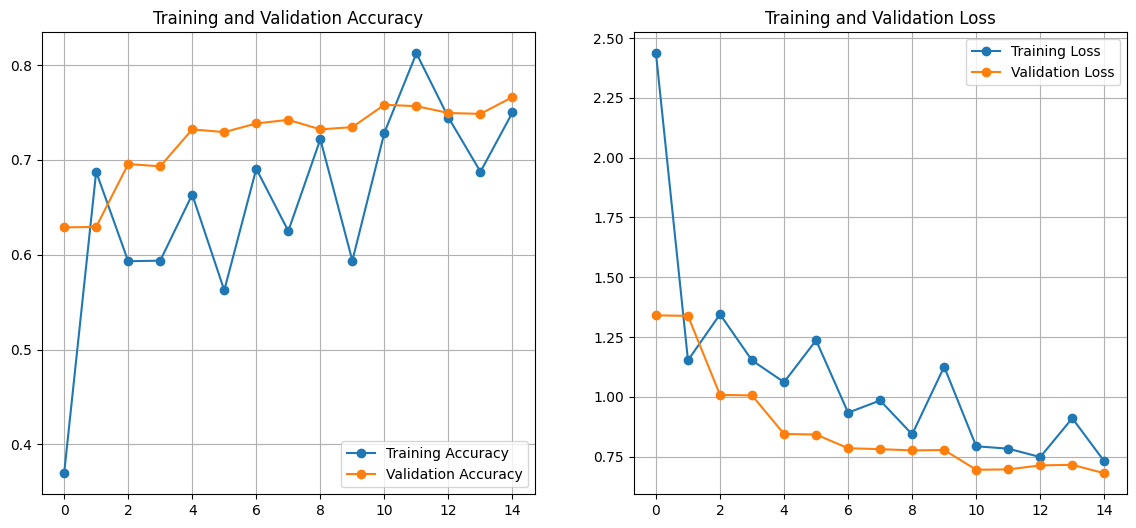

In [36]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

plot_history(history)

PERFORMANCE MEASURE

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

print("Evaluating model performance on the validation set...")

# Get the true labels from the validation generator
y_true = validation_generator.classes

# Predict the classes for the validation set
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / BATCH_SIZE)))
y_pred = np.argmax(Y_pred, axis=1)

# --- METRIC CALCULATIONS ---

# 1. Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"## Overall Accuracy: {accuracy:.4f}\n")

# 2. Precision, Recall (Sensitivity), F1-Score
# This report provides the main metrics per class and their averages.
print("## Classification Report (Precision, Recall/Sensitivity, F1-Score):")
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Specificity
# Specificity needs to be calculated on a per-class basis (one-vs-rest).
# Specificity = True Negatives / (True Negatives + False Positives)
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    # For class i
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

Evaluating model performance on the validation set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step
## Overall Accuracy: 0.8190

## Classification Report (Precision, Recall/Sensitivity, F1-Score):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.70      0.93      0.80        30
          10       1.00      0.90      0.95        30
          11       0.94      1.00      0.97        30
          12       0.94      0.97      0.95        30
          13       0.96      0.90      0.93        30
          14       0.96      0.83      0.89        30
          15       0.96      0.80      0.87        30
          16       0.77      0.57      0.65        30
          17       0.87      0.87      0.87        30
          18       0.93      0.87      0.90        30
          19       0.90      0.90      0.90        30
           2       0.57      0.13      0.22        30
          20       0.61      0.86      0.71       

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

FINAL EVALUATION ON TEST DATA

In [38]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Final Evaluation on the Unseen Test Set ---")

# 1. Load the best saved model
# Make sure the filename matches the one you saved in the fine-tuning step
final_model = load_model("indian_traffic_sign_finetuned.h5")

# 2. Create a data generator for the test set
# IMPORTANT: No augmentation, just rescaling. Shuffle must be False.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Evaluate the model to get loss and accuracy
print("\nCalculating Test Loss and Accuracy...")
test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"## Test Accuracy: {test_accuracy:.4f}")
print(f"## Test Loss: {test_loss:.4f}")

# 4. Generate a detailed classification report
print("\n--- Test Classification Report ---")

# Get true labels
y_true = test_generator.classes

# Predict probabilities
Y_pred_probs = final_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / BATCH_SIZE)))
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred_probs, axis=1)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Calculate Average Specificity for the test set
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Test Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

--- Final Evaluation on the Unseen Test Set ---


Found 2140 images belonging to 58 classes.


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Calculating Test Loss and Accuracy...
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.7883 - loss: 0.5954
## Test Accuracy: 0.8065
## Test Loss: 0.5154

--- Test Classification Report ---
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.84      0.84      0.84        31
          10       1.00      0.81      0.89        31
          11       0.91      0.97      0.94        31
          12       0.94      0.94      0.94        31
          13       0.93      0.90      0.92        31
          14       1.00      0.94      0.97        31
          15       0.93      0.87      0.90        31
          16       0.69      0.65      0.67        31
          17       0.77      0.77      0.77        31
          18       0.96      0.84      0.90        31
          19       0.85      0.94      0.89        31
           2       0.36      0.13      0.19        31
    

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

ADVERSARIAL ROBUSTNESS

In [39]:
pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: adversarial-robustness-toolbox in c:\users\vinay venkatachalam\appdata\local\programs\python\python311\lib\site-packages (1.20.1)




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


GENERATE AND VISUALIZE ADVERSARIAL EXAMPLE

Model loaded successfully.
Loaded a batch of 32 test images.
Generating adversarial examples with FGSM...
Generation complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


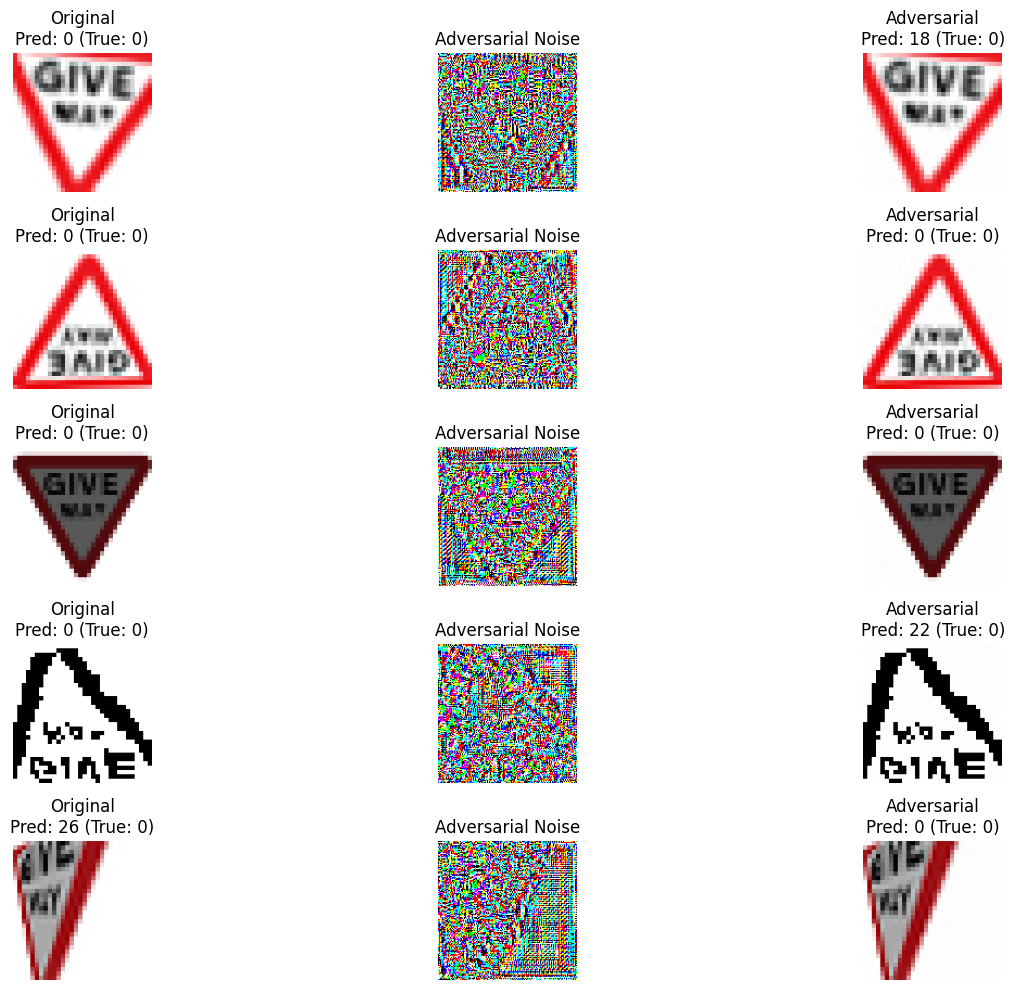

In [40]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load your trained model ---
model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")
print("Model loaded successfully.")

# --- 2. Create an ART Classifier ---
# The ART library needs a wrapper around your Keras model.
# We need to define the input shape and the number of classes.
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES, # NUM_CLASSES should be defined from your data loading cell
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # IMG_HEIGHT/WIDTH from your config cell
    loss_object=model.loss # Use the model's own loss function
)

# --- 3. Set up the FGSM Attack ---
# Epsilon (eps) controls the "strength" of the attack.
# A smaller epsilon means less visible noise but a potentially weaker attack.
attack = FastGradientMethod(estimator=classifier, eps=0.01)

# --- 4. Get a batch of clean test images ---
# Make sure your test_generator is created and available from the previous cell
# We need to get the images AND their true labels
x_test_batch, y_test_batch = next(test_generator)
print(f"Loaded a batch of {x_test_batch.shape[0]} test images.")

# --- 5. Generate adversarial examples ---
print("Generating adversarial examples with FGSM...")
x_test_adv = attack.generate(x=x_test_batch)
print("Generation complete.")

# --- 6. Test the model on clean and adversarial images ---
preds_clean = model.predict(x_test_batch)
preds_adv = model.predict(x_test_adv)

# --- 7. Visualize the results ---
# Let's show the first 5 examples
n_examples = 5
plt.figure(figsize=(15, 10))

for i in range(n_examples):
    clean_label = np.argmax(preds_clean[i])
    adv_label = np.argmax(preds_adv[i])
    true_label = np.argmax(y_test_batch[i])

    # Original Image
    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(x_test_batch[i])
    plt.title(f"Original\nPred: {clean_label} (True: {true_label})")
    plt.axis('off')

    # The Noise (Adversarial Perturbation)
    noise = x_test_adv[i] - x_test_batch[i]
    # We "normalize" the noise to make it visible
    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow((noise - noise.min()) / (noise.max() - noise.min()))
    plt.title("Adversarial Noise")
    plt.axis('off')
    
    # Adversarial Image
    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(x_test_adv[i])
    plt.title(f"Adversarial\nPred: {adv_label} (True: {true_label})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


QUANTIFY THE ATTACK SUCCESS

In [42]:
import numpy as np
from tqdm.notebook import tqdm

print("Evaluating model accuracy on the full test set...")

# --- A. Accuracy on Clean Data ---
loss_clean, acc_clean = model.evaluate(test_generator, verbose=0)
print(f"Accuracy on CLEAN test data: {acc_clean * 100:.2f}%")

# --- B. Accuracy on Adversarial Data ---
y_true_all = []
y_pred_adv_all = []

# Loop through the entire test generator
for x_batch, y_batch in tqdm(test_generator, desc="Generating and Predicting"):
    # Stop if we've gone through the whole dataset
    if len(y_true_all) >= test_generator.samples:
        break
    
    # Generate adversarial examples for the current batch using the 'attack' object from the previous cell
    x_batch_adv = attack.generate(x=x_batch)
    
    # Get model predictions on the adversarial batch
    preds_adv = model.predict(x_batch_adv, verbose=0)
    y_pred_adv = np.argmax(preds_adv, axis=1)
    
    # Store the true labels and adversarial predictions
    y_true_all.extend(np.argmax(y_batch, axis=1))
    y_pred_adv_all.extend(y_pred_adv)

# Calculate the final accuracy on all adversarial examples
acc_adv = np.sum(np.array(y_pred_adv_all) == np.array(y_true_all)) / len(y_true_all)
print(f"Accuracy on ADVERSARIAL test data: {acc_adv * 100:.2f}%")

Evaluating model accuracy on the full test set...
Accuracy on CLEAN test data: 80.65%


Generating and Predicting:   0%|          | 0/67 [00:00<?, ?it/s]

Accuracy on ADVERSARIAL test data: 32.48%


IMPLEMENT THE DEFENSE

In [43]:
import numpy as np
from tqdm.notebook import tqdm

def extract_from_generator(generator):
    """Extracts all images and labels from a Keras generator into NumPy arrays."""
    x_list, y_list = [], []
    
    # Use tqdm for a progress bar
    for i in tqdm(range(len(generator)), desc=f"Extracting from {generator.directory.split('/')[-1]}"):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
        
    # Concatenate all batches into single arrays
    x_array = np.concatenate(x_list, axis=0)
    y_array = np.concatenate(y_list, axis=0)
    
    return x_array, y_array

print("Extracting training data into memory...")
x_train, y_train = extract_from_generator(train_generator)

print("\nExtracting validation data into memory...")
x_val, y_val = extract_from_generator(validation_generator)

print(f"\nData extraction complete.")
print(f"Training images shape: {x_train.shape}")
print(f"Validation images shape: {x_val.shape}")

Extracting training data into memory...


Extracting from split_dataset\train:   0%|          | 0/305 [00:00<?, ?it/s]


Extracting validation data into memory...


Extracting from split_dataset\validation:   0%|          | 0/66 [00:00<?, ?it/s]


Data extraction complete.
Training images shape: (9743, 128, 128, 3)
Validation images shape: (2088, 128, 128, 3)


In [44]:
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
import tensorflow as tf

# --- 1. Load your ORIGINAL clean model again ---
clean_model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")

# --- THE FIX: Create a fresh optimizer instance ---
# Instead of using `clean_model.optimizer`, we create a new one.
# This ensures its internal state is perfectly synced with the loaded model.
# Use the same settings as your last successful fine-tuning run.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# --- 2. Create a new ART classifier with the NEW optimizer ---
robust_classifier = TensorFlowV2Classifier(
    model=clean_model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(), # Explicitly define the loss
    optimizer=optimizer # Pass the NEW optimizer to the wrapper
)

# --- 3. Create the Adversarial Trainer ---
attack = FastGradientMethod(estimator=robust_classifier, eps=0.01)
trainer = AdversarialTrainer(robust_classifier, attacks=attack, ratio=0.5)

# --- 4. Train the robust model using the NumPy arrays ---
print("\nStarting adversarial training...")
trainer.fit(
    x=x_train, 
    y=y_train, 
    nb_epochs=10, 
    validation_data=(x_val, y_val)
)

# --- 5. Save your new, robust model ---
robust_model = trainer.get_classifier().model
robust_model.save("indian_traffic_sign_robust.h5")
print("\nRobust model saved as 'indian_traffic_sign_robust.h5'")


Starting adversarial training...


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Robust model saved as 'indian_traffic_sign_robust.h5'


EVALUATE THE NEW ROBUST MODEL

In [45]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

# --- 1. Load your NEW robust model ---
robust_model = tf.keras.models.load_model("indian_traffic_sign_robust.h5")

# --- 2. Evaluate on CLEAN data ---
loss_robust_clean, acc_robust_clean = robust_model.evaluate(test_generator, verbose=0)
print(f"ROBUST model accuracy on CLEAN test data: {acc_robust_clean * 100:.2f}%")

# --- 3. Evaluate on ADVERSARIAL data ---

# THE FIX: We must define the loss_object when creating the classifier
robust_art_classifier = TensorFlowV2Classifier(
    model=robust_model, 
    nb_classes=NUM_CLASSES, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy() # <-- This line was missing
)

# We create the attack targeted at the NEW robust model
# I've also updated eps to 0.01 to be consistent with our decision to use a more subtle attack.
attack_on_robust = FastGradientMethod(estimator=robust_art_classifier, eps=0.01)

y_true_all_robust = []
y_pred_adv_all_robust = []

for x_batch, y_batch in tqdm(test_generator, desc="Attacking Robust Model"):
    if len(y_true_all_robust) >= test_generator.samples:
        break
    
    x_batch_adv_robust = attack_on_robust.generate(x=x_batch)
    preds_adv_robust = robust_model.predict(x_batch_adv_robust, verbose=0)
    y_pred_adv_robust = np.argmax(preds_adv_robust, axis=1)
    
    y_true_all_robust.extend(np.argmax(y_batch, axis=1))
    y_pred_adv_all_robust.extend(y_pred_adv_robust)

acc_robust_adv = np.sum(np.array(y_pred_adv_all_robust) == np.array(y_true_all_robust)) / len(y_true_all_robust)
print(f"ROBUST model accuracy on ADVERSARIAL test data: {acc_robust_adv * 100:.2f}%")

ROBUST model accuracy on CLEAN test data: 82.62%


Attacking Robust Model:   0%|          | 0/67 [00:00<?, ?it/s]

ROBUST model accuracy on ADVERSARIAL test data: 40.65%
